In [265]:
using RobustAndOptimalControl
using ControlSystemsBase 
using Plots

In [266]:
function parse_tf_from_file(fname)

    file = open(fname, "r")
    lines = readlines(file)
    close(file)

    # join to one String
    lines = join(lines)
    num = split(lines, "]")[1]
    num = replace(num, "[" => "")

    den = split(lines, "]")[2]
    den = replace(den, "[" => "")
    den = replace(den, "]" => "")


    num_f = []
    for fs in split(num, " ")
        if fs == ""
            continue
        end
        push!(num_f, parse(Float64, fs))
    end

    den_f = []
    for fs in split(den, " ")
        if fs == ""
            continue
        end
        push!(den_f, parse(Float64, fs))
    end

    num_f = Vector{Float64}(num_f)
    den_f = Vector{Float64}(den_f)


    G = tf(num_f, den_f)
    G = minreal(G)
    return G
end

parse_tf_from_file (generic function with 1 method)

# Plant

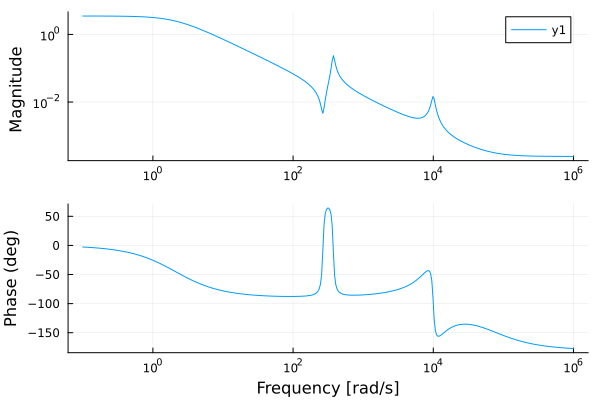

In [267]:
s = tf("s")
G = parse_tf_from_file("tf_txt/Gf.txt")

bodeplot(G)

In [268]:
function pt2(w0,d)
    s = tf("s")
    return w0^2/(s^2 + 2*d*w0*s + w0^2)
end

pt2 (generic function with 1 method)

# Uncertainty

StateSpace{Continuous, Float64}
D = 
 1.1

Continuous-time state-space model

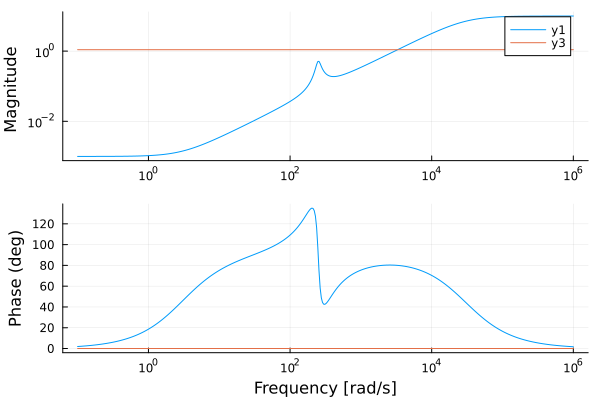

In [269]:

W1 = 0.1
W2 = pt2(250,0.1)/pt2(250,0.8)
W3 = (s/3000 + 1)^2/(s/(5*1e5) + 1)^2
W_delta = W1*W2*W3


ROB_SCALE = 1 # Increase for more robustness
W_delta = makeweight(0.01, 2000, 40) |> tf
#W_delta = W_delta* pt2(280,0.2)/(pt2(280,2)) * ROB_SCALE
W_delta = W_delta* pt2(270,0.1)/(pt2(270,0.8)) * ROB_SCALE
W_delta0 = parse_tf_from_file("tf_txt/W_delta.txt")

W_delta = ss(1)*1.09
W_delta = parse_tf_from_file("tf_txt/W_delta.txt")

W_delta = ss(1.1)


print(W_delta)

bodeplot([W_delta0,W_delta])



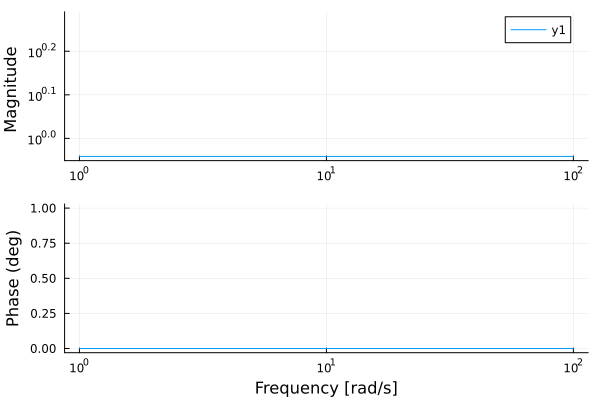

In [270]:
bodeplot(1/W_delta)

# Control limit

50265.48245743669

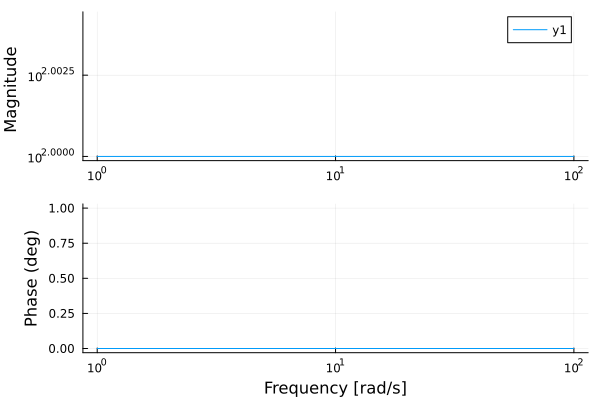

In [271]:


# Max Torque, and Nyquist freq as dynamic limit
w_nyq = 2*pi/(125*1e-6)
print(w_nyq)
max_T = 50


WU = pt2(200,1)/pt2(500,1) * 500 # best so far



WU = pt2(150,1)/pt2(300,1) * 300 

inf_gain = evalfr(WU, im*1e6)
inf_gain = abs(inf_gain[1,1])

#WU = WU/abs(inf_gain) * 45
WU = WU/abs(inf_gain) * 60

WU =  220.0*ss(1.0)
WU = 100*ss(1.0)

bodeplot(WU)


In [272]:
WU = 1/WU

StateSpace{Continuous, Float64}
D = 
 0.01

Continuous-time state-space model

0.165
198.0
3853.85
4620.0

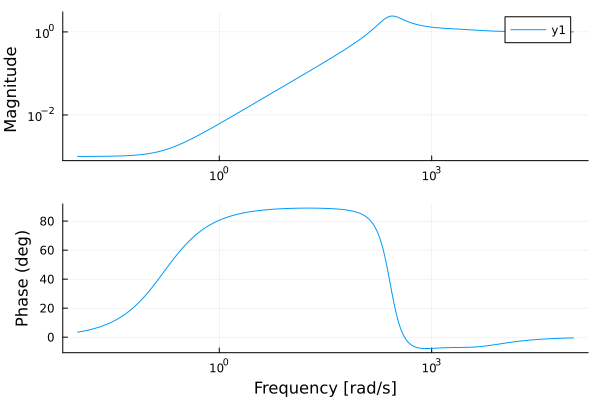

In [273]:
# Desired closed loop bw rad/s
omega_cl = 30*6.6
omega_max = 700*6.6

S_max = 1.2
S_inf = 1.001
S_L = 1e-3


omega_0 = omega_cl/S_max * S_L

omega_r = S_inf/S_max * omega_max

print(omega_0)
print('\n')
print(omega_cl)
print('\n')
print(omega_r)
print('\n')
print(omega_max)


WS = (s/omega_0 + 1)/(s/omega_cl + 1) * (s/omega_max + 1)/(s/omega_r + 1)*S_L * pt2(260,0.4)/pt2(260,1.0)

WS = 1/WS

bodeplot(1/WS)

In [274]:

WT = W_delta

P = hinfpartition(G, WS, WU, WT)
hinfassumptions(P)



All assumtions are satisfied!


true

1.1683266370283796

┌ Warning: Numerical problems encountered, returned γ is adjusted to the γ achieved by the computed controller (γ - γactual = 0.003276140636042646). Try solving the problem in higher precision by calling hinfsynthesize(...; ftype=BigFloat)
└ @ RobustAndOptimalControl C:\Users\Elias\.julia\packages\RobustAndOptimalControl\Qj5nj\src\hinfinity_design.jl:203


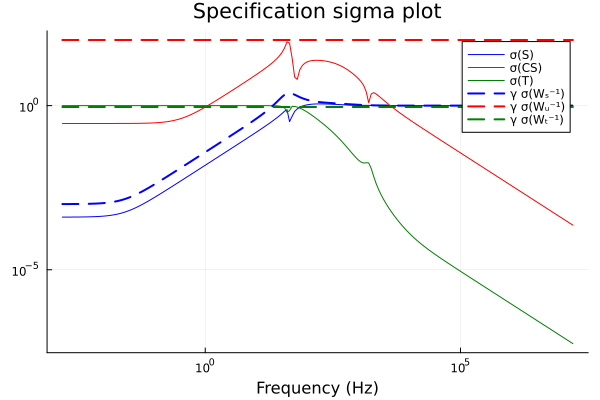

In [275]:
K, y = hinfsynthesize(P, γrel=1.05)

K = minreal(K)

print(y)



Pcl, S, KS, T = hinfsignals(P, G, K)


specificationplot([S,K*S,T], [WS,WU,WT],wint=(-2,8))


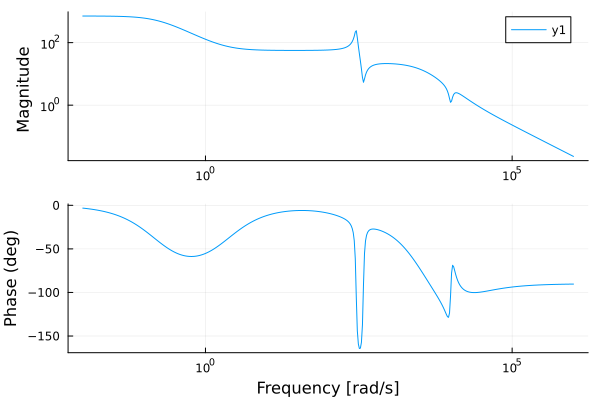

In [276]:
bodeplot(K)

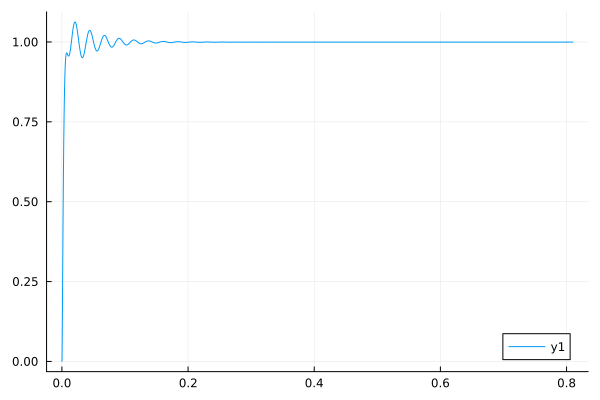

In [277]:
Pcl = G*K/(1 + G*K)

Pcl = minreal(Pcl)
y, t = step(Pcl);
plot(t, y')

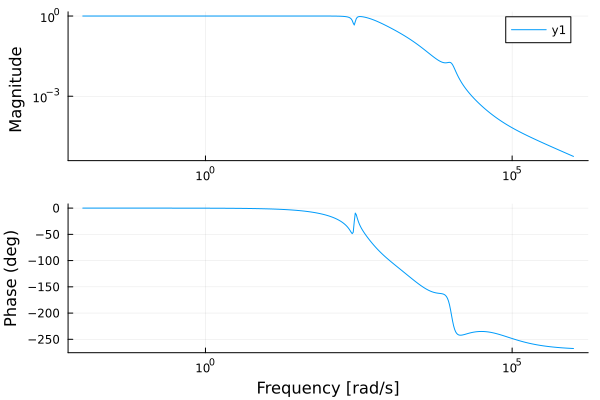

In [278]:



bodeplot(Pcl)

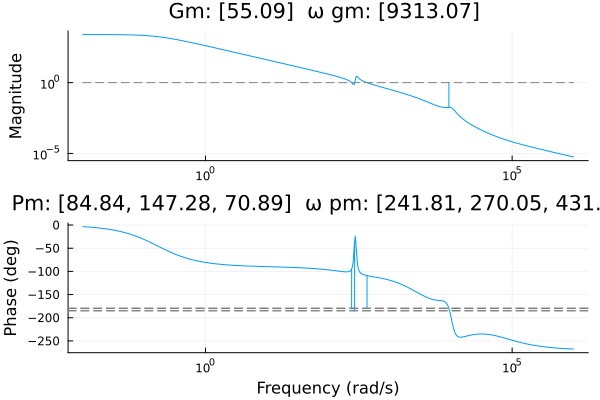

In [279]:
L = minreal(G*K)
marginplot(L)

In [280]:
K = tf(K)

num = K.matrix[1,1].num.coeffs
den = K.matrix[1,1].den.coeffs

fpath = "tf_txt/K_hinf.txt"
open(fpath, "w") do file
    write(file, string(num))
    write(file, "\n")
    write(file, string(den))
end

K

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
    22830.439999920152s^8 + 4.2152139810575837e8s^7 + 2.952599823597836e12s^6 + 4.02408123502141e16s^5 + 2.7224281269789815e19s^4 + 1.012732537757436e22s^3 + 3.6996161187642417e24s^2 + 5.223985864074258e26s + 1.0795759443981192e27
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^9 + 11691.007396810859s^8 + 1.524858787440712e8s^7 + 9.758637747505905e11s^6 + 2.1650018683893045e15s^5 + 1.0517210133101889e18s^4 + 3.088149987013397e20s^3 + 7.829056032312933e22s^2 + 9.190258717143394e24s + 1.5142626142803352e24

Continuous-time transfer function model